# 1D Heat Equation with Forward Euler and Crank–Nicolson

In this notebook, we will solve the 1D heat (diffusion) equation:
\begin{align}
    \frac{\partial T(x,t)}{\partial t} &= \alpha\,\frac{\partial^2 T(x,t)}{\partial x^2} + q(x) 
\end{align}

subject to some boundary conditions and an initial condition. We will:

1. Discretize space using a uniform grid of spacing $\Delta x$.
2. Discretize time using a timestep $\Delta t$.
3. Implement two different time-stepping schemes:
   - **Forward Euler** (explicit): Easy to code but can become unstable if $\Delta t$ is large.
   - **Crank–Nicolson** (implicit): Generally stable for larger timesteps and second-order accurate in time.

We'll go step by step to explain how the matrices are set up and how we evolve the solution in time.

## 1. Imports and Parameter Definitions

Here, we import NumPy (for numerical arrays and linear algebra) and Matplotlib (for plotting). Then we set up:
- The length of the domain (`length`).
- The total simulation time (`total_time`).
- The thermal diffusivity (`alpha`).
- The spatial and temporal discretization steps (`delta_x` and `delta_t`).
- The parameter `gamma = alpha * delta_t / (delta_x^2)`, which often appears in finite-difference solutions of the diffusion equation.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Physical length of the 1D rod (meters)
length = 0.1  

# Total simulation time (seconds)
total_time = 50  

# Thermal diffusivity (alpha, in m^2/s)
alpha = 0.0001  

# Spatial step (m)
delta_x = 0.005

# Time step (s)
delta_t = 0.1

# Dimensionless factor for the diffusion term
gamma = (alpha * delta_t) / (delta_x ** 2)
print("gamma:", gamma)

# Number of spatial points
num_points = int(length / delta_x)

# Number of time steps
num_time_steps = int(total_time / delta_t)

print("Number of spatial points:", num_points)
print("Number of temporal points:", num_time_steps)

gamma: 0.4
Number of spatial points: 20
Number of temporal points: 500


## 2. Setting Up Initial Condition & Source Term

We define:
- `T0`: The temperature distribution at $t=0$ across the spatial domain.
- `q`: A source term array for each spatial point. You can imagine this as heat being generated internally at particular locations.

In [7]:
# Set the initial temperature distribution (all zeros here)
T0 = np.zeros(num_points)
print("Initial condition, T0:", T0)

# Source term in the domain
q = np.zeros(num_points)
# You can modify q below; e.g. add localized sources:
q[int(num_points/2)] = 0.2   # Heat source in the middle
q[int(num_points/4)] = 0.1   # Heat source at quarter-length
print("Source term, q:", q)

Initial condition, T0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Source term, q: [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]


## 3. Building the Spatial Finite-Difference Matrix

To handle the second spatial derivative, we create a matrix $A$ such that

 \begin{pmatrix}
 -2\gamma & +\gamma    & 0       & \ldots   & 0 \\
 +\gamma   & -2\gamma  & +\gamma & \ldots   & 0 \\
 0         & +\gamma    & -2\gamma & +\gamma  & 0 \\
 \vdots    & \vdots     & \vdots    & \ddots   & +\gamma \\
 0         & 0          & 0         & +\gamma  & -2\gamma
\end{pmatrix}

However, at the boundaries, we slightly modify the diagonal entries to represent Neumann boundary conditions. This approximate method ensures the flux at the boundary is zero.

### Exercise 1: Dirichlet Boundary Conditions

**Task:**  
Keep the boundary temperatures fixed at $T_{\text{left}}$ and $T_{\text{right}}$.

**Hints:**
- Update the interior points using your finite-difference stencil.
- Manually set the left boundary to $T_{\text{left}}$ and the right boundary to $T_{\text{right}}$.
- Start with initial conditions that already satisfy these fixed values.

---

### Exercise 2: Neumann Boundary Conditions

**Task:**  
Ensure the boundary flux (derivative) is correctly imposed (e.g., zero flux).

**Hints:**
- Enforce $\frac{\partial T}{\partial x} = 0 $ at the boundaries.
- Use ghost points (for example, set $ T_{-1} = T_1 $ or one-sided finite differences to approximate the derivative.
- Modify the finite-difference matrix to adjust the boundary entries appropriately.
- Verify that the flux at the boundaries matches the desired condition.

In [8]:
# Main diagonal: -2 * gamma
on = -2.0 * gamma * np.ones(num_points)

# Off-diagonals: + gamma
off = gamma * np.ones(num_points - 1)

# Build the diffusion matrix
A = np.diag(on) + np.diag(off, 1) + np.diag(off, -1)

# Adjust for Neumann boundaries
# Usually, we do something like A[0,0] = -1*gamma or a more precise method.
A[0, 0] = -1.0 * gamma
A[num_points - 1, num_points - 1] = -1.0 * gamma

print("Matrix A (top-left corner):\n", A[:5,:5])

Matrix A (top-left corner):
 [[-0.4  0.4  0.   0.   0. ]
 [ 0.4 -0.8  0.4  0.   0. ]
 [ 0.   0.4 -0.8  0.4  0. ]
 [ 0.   0.   0.4 -0.8  0.4]
 [ 0.   0.   0.   0.4 -0.8]]


## 4. Forward Euler Time Stepping

### Forward Euler Update

When discretized in time using an **explicit** (Forward Euler) scheme, the 1D heat equation

$$
\frac{\partial T}{\partial t} \;=\; \alpha \frac{\partial^2 T}{\partial x^2} \;+\; q(x)
$$

transforms into the update formula:

$$
T^{n+1} \;=\; T^n \;+\; A \, T^n \;+\; q.
$$

In more explicit matrix-vector notation, this becomes:

$$
T_{\text{next}} \;=\; A \,\bigl(T_{\text{current}}\bigr) \;+\; T_{\text{current}} \;+\; q,
$$

which in Python can be written as:
```python
T_next = A @ T_current + T_current + q

In [9]:
# Storage for temperature at each time step
T_forward = np.zeros((num_time_steps, num_points))

# Initialize the solution
T_forward[0, :] = T0

# Time-marching using Forward Euler
T_current = T0.copy()

for n in range(1, num_time_steps):
    # Update rule
    T_next = T_current + A @ T_current + q
    
    # Store
    T_forward[n, :] = T_next
    # Prepare for next iteration
    T_current = T_next

print("Final temperature (Forward Euler):", T_forward[-1, :])

Final temperature (Forward Euler): [7.42518034 7.46276823 7.53794186 7.65069695 7.80102721 7.98892452
 7.96437909 7.97737972 8.0279141  8.11596906 8.24153094 7.9045859
 7.60512027 7.34312091 7.11857548 6.93147279 6.78180305 6.66955814
 6.59473177 6.55731966]


### Plotting the Result (Forward Euler)
We'll plot how the temperature looks at the **final time** and also show the evolution.

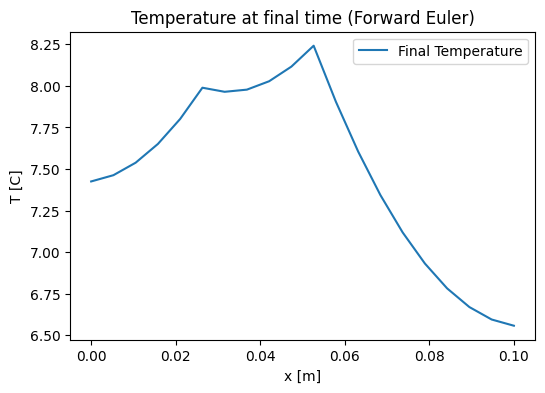

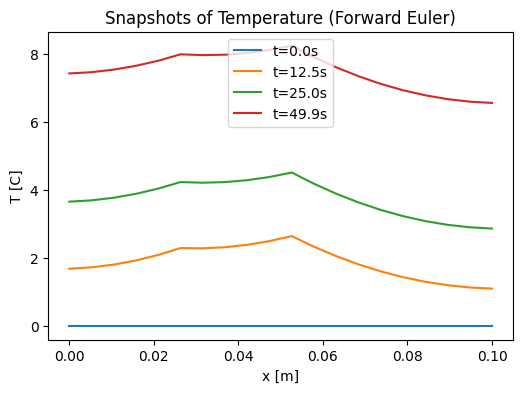

In [10]:
# Plot the final temperature distribution in space
x_vals = np.linspace(0, length, num_points)
plt.figure(figsize=(6,4))
plt.plot(x_vals, T_forward[-1, :], label='Final Temperature')
plt.title('Temperature at final time (Forward Euler)')
plt.xlabel('x [m]')
plt.ylabel('T [C]')
plt.legend()
plt.show()

# OPTIONAL: Plot a few snapshots in time
snap_indices = [0, int(num_time_steps/4), int(num_time_steps/2), num_time_steps-1]
plt.figure(figsize=(6,4))
for idx in snap_indices:
    plt.plot(x_vals, T_forward[idx, :], label=f't={idx*delta_t:.1f}s')
plt.title('Snapshots of Temperature (Forward Euler)')
plt.xlabel('x [m]')
plt.ylabel('T [C]')
plt.legend()
plt.show()

## 5. Crank–Nicolson Method

To derive the Crank–Nicolson update, we begin with the 1D heat equation:
$$
\frac{\partial T}{\partial t} = \alpha\,\frac{\partial^2 T}{\partial x^2} + q.
$$

We apply a **central-difference** approximation in time at the midpoint between $t^n$ and $t^{n+1}$. Concretely, the time derivative $\frac{\partial T}{\partial t}$ is approximated by
$$
\frac{T^{n+1}_j - T^n_j}{\Delta t},
$$
and we average the spatial second derivative between time levels $n$ and $n+1$. This yields:
$$
\frac{T^{n+1}_j - T^n_j}{\Delta t} = \alpha\,
\frac{
\bigl(T^n_{j+1} - 2\,T^n_j + T^n_{j-1}\bigr)
+
\bigl(T^{n+1}_{j+1} - 2\,T^{n+1}_j + T^{n+1}_{j-1}\bigr)
}{
2\,(\Delta x)^2} + q_j.
$$

Rewriting, we obtain:
$$
T^{n+1}_j - T^n_j = \frac{\Delta t\,\alpha}{2\,(\Delta x)^2}
\Bigl(
  T^n_{j+1} - 2\,T^n_j + T^n_{j-1} 
  + T^{n+1}_{j+1} - 2\,T^{n+1}_j + T^{n+1}_{j-1}
\Bigr)
+ \Delta t\,q_j.
$$

Summarizing in vector/matrix form for all spatial points:
$$
\bigl(I - \tfrac{\gamma}{2}\,D\bigr)\,T^{n+1}
= \bigl(I + \tfrac{\gamma}{2}\,D\bigr)\,T^{n} + \Delta t\,q,
$$
where
$$
\gamma = \frac{\alpha\,\Delta t}{(\Delta x)^2},
$$
and $D$ is the **Laplacian matrix** (the discrete second derivative in space).

### Key takeaway

Crank–Nicolson averages the diffusion term at both time levels $n$ and $n+1$. This makes the scheme implicit, requiring the solution of a linear system each timestep, but it achieves better stability and second-order accuracy in time compared to simple explicit (Forward Euler) methods.

In [11]:
# 1) Build the core diffusion matrix D (not multiplied by gamma yet)
D_main = -2.0 * np.ones(num_points)
D_off = np.ones(num_points - 1)
D_mat = (np.diag(D_main) + np.diag(D_off, 1) + np.diag(D_off, -1))

# Adjust boundaries for Neumann by halving the diagonal at edges:
D_mat[0, 0] = -1.0  # approximate
D_mat[-1, -1] = -1.0

# 2) Construct M_L and M_R
# I is the identity matrix of size (num_points x num_points)
I_mat = np.eye(num_points)

M_L = I_mat - (gamma/2.0)*D_mat  # (I - gamma/2 * D)
M_R = I_mat + (gamma/2.0)*D_mat  # (I + gamma/2 * D)

print("Matrix M_L (top-left corner):\n", M_L[:5,:5], "\n")
print("Matrix M_R (top-left corner):\n", M_R[:5,:5])

Matrix M_L (top-left corner):
 [[ 1.2 -0.2  0.   0.   0. ]
 [-0.2  1.4 -0.2  0.   0. ]
 [ 0.  -0.2  1.4 -0.2  0. ]
 [ 0.   0.  -0.2  1.4 -0.2]
 [ 0.   0.   0.  -0.2  1.4]] 

Matrix M_R (top-left corner):
 [[0.8 0.2 0.  0.  0. ]
 [0.2 0.6 0.2 0.  0. ]
 [0.  0.2 0.6 0.2 0. ]
 [0.  0.  0.2 0.6 0.2]
 [0.  0.  0.  0.2 0.6]]


### 6. Time Loop for Crank–Nicolson
The update at each time step is:
$$
M_L\,T^{n+1} = M_R\,T^{n} + \Delta t\,q. 
$$
We'll store the results in $T_cn$ just like we did for the forward Euler solution.

In [12]:
T_cn = np.zeros((num_time_steps, num_points))

# Initial condition
T_cn[0,:] = T0
T_current = T0.copy()

for n in range(1, num_time_steps):
    # Right-hand side
    RHS = M_R @ T_current + (delta_t)*q  # source multiplied by dt

    # Solve for T^{n+1}
    T_next = np.linalg.solve(M_L, RHS)

    # Store and proceed
    T_cn[n,:] = T_next
    T_current = T_next

print("Final temperature (Crank-Nicolson):", T_cn[-1, :])

Final temperature (Crank-Nicolson): [0.74250924 0.74626825 0.75378604 0.76506218 0.78009602 0.79888673
 0.7964333  0.7977346  0.80278935 0.81159621 0.82415379 0.79046065
 0.7605154  0.7343167  0.71186327 0.69315398 0.67818782 0.66696396
 0.65948175 0.65574076]


## 7. Plotting the Crank–Nicolson Results
We'll do the same style of final and snapshot plots. Compare it to Forward Euler results to see differences (especially if you tweak `delta_t` and see stability issues).

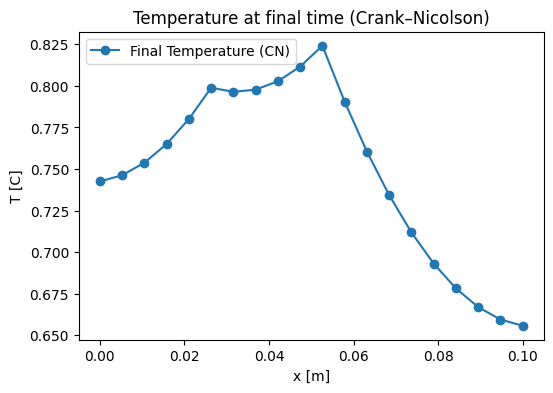

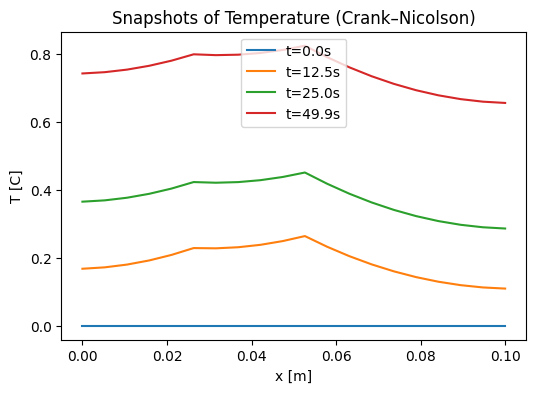

In [13]:
# Final temperature distribution for Crank-Nicolson
plt.figure(figsize=(6,4))
plt.plot(x_vals, T_cn[-1, :], 'o-', label='Final Temperature (CN)')
plt.title('Temperature at final time (Crank–Nicolson)')
plt.xlabel('x [m]')
plt.ylabel('T [C]')
plt.legend()
plt.show()

# Snapshots in time
snap_indices = [0, int(num_time_steps/4), int(num_time_steps/2), num_time_steps-1]
plt.figure(figsize=(6,4))
for idx in snap_indices:
    plt.plot(x_vals, T_cn[idx, :], label=f't={idx*delta_t:.1f}s')
plt.title('Snapshots of Temperature (Crank–Nicolson)')
plt.xlabel('x [m]')
plt.ylabel('T [C]')
plt.legend()
plt.show()